In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

### Dataset:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Source: Data Source :http://data.seoul.go.kr/
SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

In [144]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("data/SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)

In [145]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)

In [146]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


In [147]:
"""
for label in df.columns[1:]:
    plt.scatter(df[label], df["bike_count"])
    plt.title(label)
    plt.ylabel("Bike Count at Noon")
    plt.xlabel(label)
    plt.show()
"""

'\nfor label in df.columns[1:]:\n    plt.scatter(df[label], df["bike_count"])\n    plt.title(label)\n    plt.ylabel("Bike Count at Noon")\n    plt.xlabel(label)\n    plt.show()\n'

In [148]:
df = df.drop(["wind", "visibility", "functional"], axis=1)

In [149]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Train/Validation/Test Dataset

In [150]:
train, validation, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [151]:
def get_xy(dataframe, y_label, x_labels = None):
    dataframe = copy.deepcopy(dataframe)
    
    if x_labels is None:
        x = dataframe[[c for c in dataframe.columns if c != y_label]].values
    else:
        if len(x_labels) == 1:
            x = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            x = dataframe[x_labels].values
            
    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((x, y))
    
    return data, x, y

In [152]:
_, x_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels = ["temp"])
_, x_validation_temp, y_validation_temp = get_xy(validation, "bike_count", x_labels = ["temp"])
_, x_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels = ["temp"])

In [153]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)

LinearRegression()

In [154]:
temp_reg.score(x_test_temp, y_test_temp)

0.29952659065060194

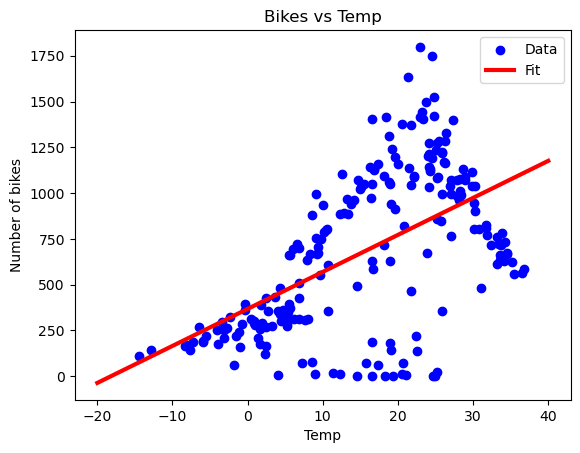

In [155]:
plt.scatter(x_train_temp, y_train_temp, label = "Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x,).reshape(-1, 1)), label = "Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Multiple Linear Regression

In [156]:
train, validation, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

_, x_train_all, y_train_all = get_xy(train, "bike_count", x_labels = df.columns[1:])
_, x_validation_all, y_validation_all = get_xy(validation, "bike_count", x_labels = df.columns[1:])
_, x_test_all, y_test_all = get_xy(test, "bike_count", x_labels = df.columns[1:])

In [157]:
all_reg = LinearRegression()
all_reg = all_reg.fit(x_train_all, y_train_all)

In [158]:
all_reg.score(x_test_all, y_test_all)

0.38284971035432247

# Regression With Neural Network

In [159]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.grid(True)
    
    plt.show()

In [160]:
temp_normalizer = tf.keras.layers.Normalization(input_shape = (1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

In [161]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [162]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [163]:
history = temp_nn_model.fit(
    x_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(x_validation_temp, y_validation_temp)
)

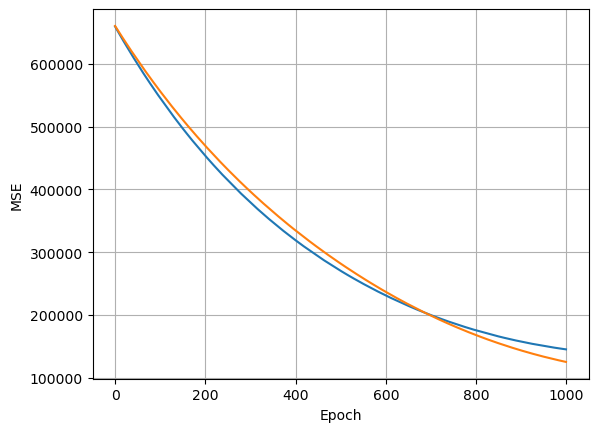

In [164]:
plot_loss(history)

4/4 [==============================] - 0s 717us/step


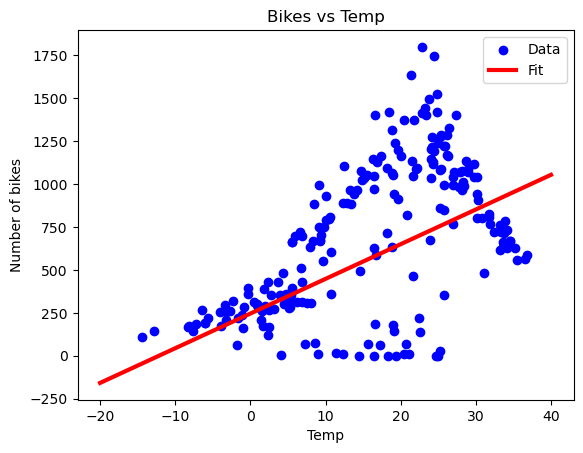

In [165]:
plt.scatter(x_train_temp, y_train_temp, label = "Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x,).reshape(-1, 1)), label = "Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Neural Network

In [166]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [167]:
history = nn_model.fit(
    x_train_temp, y_train_temp,
    validation_data=(x_validation_temp, y_validation_temp),
    verbose=0, epochs=100
)

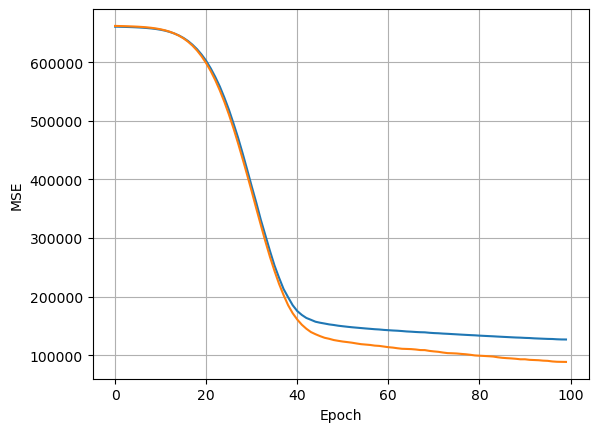

In [168]:
plot_loss(history)

4/4 [==============================] - 0s 694us/step


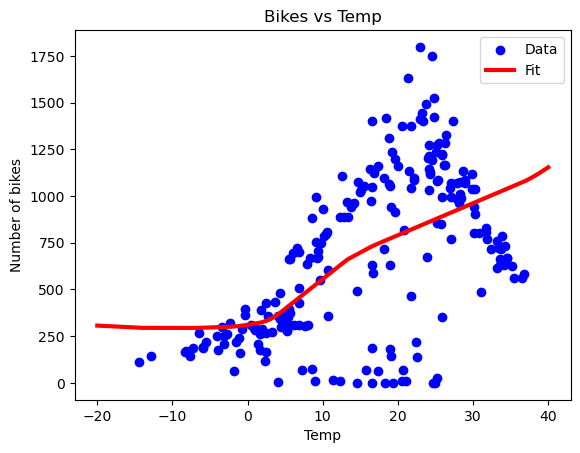

In [169]:
plt.scatter(x_train_temp, y_train_temp, label = "Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x,).reshape(-1, 1)), label = "Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

In [170]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(x_train_all)

In [171]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [172]:
history = nn_model.fit(
    x_train_all, y_train_all,
    validation_data=(x_validation_all, y_validation_all),
    verbose=0, epochs=100
)

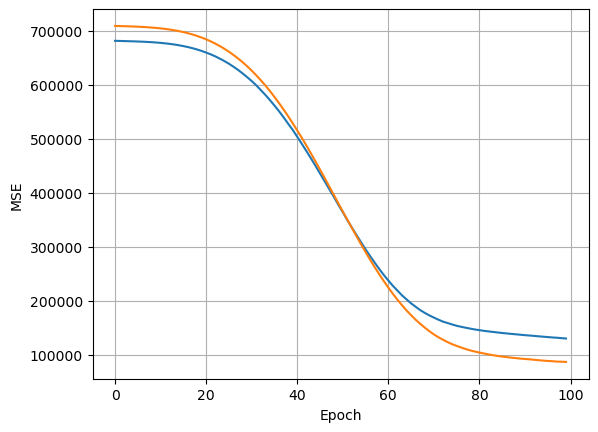

In [173]:
plot_loss(history)

In [174]:
# calculate the MSE for both linear regression and neural network
y_pred_lr = all_reg.predict(x_test_all)
y_pred_nn = nn_model.predict(x_test_all)

3/3 [==============================] - 0s 1000us/step


In [175]:
def MSE(y_pred, y_real):
    return (np.square(y_pred - y_real)).mean()

In [176]:
MSE(y_pred_lr, y_test_all)

104834.55049358736

In [177]:
MSE(y_pred_nn, y_test_all)

121383.41142571771

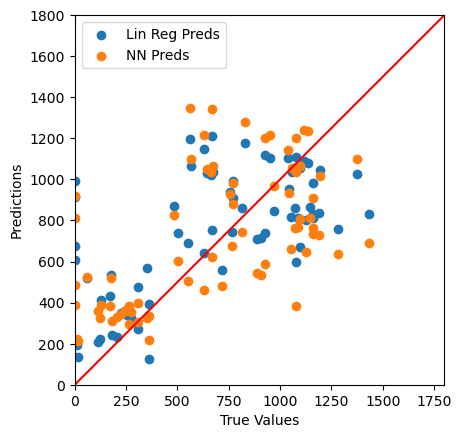

In [179]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")

lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")